Cryptocurrency trading bot.

Global variable definitions.

In [1]:
traded_asset_symbols = ['BTC', 'USDT']
intervals = ['1d']
raw_price = False
initial_plot = True

api_key = 'yoyoyo'
api_secret = 'yeyeye'

Installs.

In [2]:
!pip install plotly python-binance --upgrade --no-cache-dir

Requirement already up-to-date: plotly in ./anaconda3/lib/python3.7/site-packages (4.8.1)
Requirement already up-to-date: python-binance in ./anaconda3/lib/python3.7/site-packages (0.7.5)


Library imports.

In [3]:
%matplotlib inline

from binance.client import Client
from binance.enums import *
from binance.websockets import BinanceSocketManager
from binance.exceptions import BinanceAPIException
from twisted.internet import reactor
from IPython import display

import math
import random
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

Function definitions.

In [4]:
class Cryptocurrency_indicator:
    def __init__(self, dataset, name, calculate, OHLC=False, initial_plot=True):
        self.name = name
        self.calculate = calculate
        self.plot = self._plot_OHLC_ if OHLC else self._plot_default_
        self.value = self.update(dataset, plot=initial_plot)

    def update(self, dataset=None, plot=False):
        if dataset is not None:
            self.dataset = dataset

        self.value = self.calculate(self.dataset.astype(float))

        if plot:
            self.plot()

    def _plot_default_(self):
        value = self.value.astype(float)

        print("\n")
        print(self.name)
        print(value)
        plt.plot(value)
        plt.show()
        print("\n")

    def _plot_OHLC_(self):
        value = self.value.astype(float)

        print("\n")
        print(self.name)
        print(self.value)
        fig = go.Figure(data=[go.Candlestick(x=value.index.to_series(), 
                                             open=value['open'], 
                                             high=value['high'], 
                                             low=value['low'], 
                                             close=value['close'])])

        fig.show()
        print("\n")


class Cryptocurrency_indicators_base:
    def __init__(self):
        self.indicators = None

    def _calculate_moving_average_(self, dataset, window=2, method='simple'):
        if method == 'simple':
            dataset = dataset.rolling(window=window)
        elif method == 'exponential':
            dataset = dataset.ewm(span=window)

        dataset = dataset.mean()
        dataset = dataset.fillna(method='backfill', axis='index')
        return dataset

    def calculate_simple_moving_average(self, dataset, window=2):
        return self._calculate_moving_average_(dataset, window=window, method='simple')

    def calculate_exponential_moving_average(self, dataset, window=2):
        return self._calculate_moving_average_(dataset, window=window, method='exponential')

    def calculate_heikin_ashi(self, df):
        df = df.tz_localize(tz=None, ambiguous='infer')
        df = df[['open', 'high', 'low', 'close']].copy().astype('float')
        heikin_ashi_df = pd.DataFrame(index=df.index.values, columns=['open', 'high', 'low', 'close'])
        heikin_ashi_df['close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4

        for i in range(len(df)):
            if i == 0:
                heikin_ashi_df.iat[0, 0] = df['open'].iloc[0]
            else:
                heikin_ashi_df.iat[i, 0] = (heikin_ashi_df.iat[i - 1, 0] + heikin_ashi_df.iat[i - 1, 3]) / 2

        heikin_ashi_df['high'] = heikin_ashi_df.loc[:, ['open', 'close']].join(df['high']).max(axis=1)
        heikin_ashi_df['low'] = heikin_ashi_df.loc[:, ['open', 'close']].join(df['low']).min(axis=1)

        return heikin_ashi_df

    def calculate_RSI(self, ticker, span=14):
        up = ticker['close'].astype(float).pct_change()
        down = up.copy()
        up[up < 0.0] = 0.0
        down[down > 0.0] = 0.0

        up = up.ewm(span=span).mean().fillna(method='pad')
        down = down.ewm(span=span).mean().abs().fillna(method='pad')

        ticker = up / down
        ticker = 100 - (100 / (1 + ticker))

        ticker = ticker.replace([-np.inf, np.inf], np.nan)
        ticker.iloc[0] = ticker.iloc[1]
        return ticker.fillna(method='pad')

    def calculate_MACD(self, ticker, span1=12, span2=26, average='exponential'):
        shorter = self._calculate_moving_average_(ticker, window=span1, method=average)['close']
        longer = self._calculate_moving_average_(ticker, window=span2, method=average)['close']

        ticker = (shorter - longer).replace([-np.inf, np.inf], np.nan)
        ticker.iloc[0] = ticker.iloc[1]
        ticker = ticker.fillna(method='pad').to_frame(name='MACD')
        ticker['signal_line'] = ticker.MACD.ewm(span=9).mean()
        ticker['histogram'] = ticker.MACD - ticker.signal_line
        return ticker

    def calculate_ATR(self, ticker, min_periods=14):
        ticker = ticker.astype(float)
        up = pd.DataFrame([ticker['high'].shift(), 
                           ticker['close']]).fillna(method='backfill', axis='columns').max(axis='index')

        down = pd.DataFrame([ticker['low'].shift(), 
                             ticker['close']]).fillna(method='backfill', axis='columns').min(axis='index')

        ticker = (up - down).ewm(alpha=1 / min_periods, 
                                 min_periods=min_periods, 
                                 adjust=False).mean()

        ticker = ticker.replace([-np.inf, np.inf], np.nan)
        return ticker.fillna(method='backfill')

    def calculate_bollinger_bands(self, dataframe, period=20):
        df = dataframe.copy()
        df['MA'] = self._calculate_moving_average_(df, window=period, method='simple')['close']
        df['BB_up'] = df['MA'] + df['MA'].rolling(period).std()
        df['BB_down'] = df['MA'] - df['MA'].rolling(period).std()
        df['BB_width'] = df['BB_up'] - df['BB_down']
        return df[['BB_up', 'BB_down', 'BB_width']].dropna()

    def calculate_average_directional_index(self, df, n=14, n_ADX=14):
        dataset_index = df.index.copy()
        df = df.reset_index().drop(columns=['time']).astype(float)
        i = 0
        UpI = []
        DoI = []

        while i + 1 <= df.index[-1]:
            UpMove = df.loc[i + 1, 'high'] - df.loc[i, 'high']
            DoMove = df.loc[i, 'low'] - df.loc[i + 1, 'low']

            if UpMove > DoMove and UpMove > 0:
                UpD = UpMove
            else:
                UpD = 0

            UpI.append(UpD)

            if DoMove > UpMove and DoMove > 0:
                DoD = DoMove
            else:
                DoD = 0

            DoI.append(DoD)
            i += 1

        ATR = self.calculate_ATR(df, min_periods=14)
        UpI = pd.Series(UpI)
        DoI = pd.Series(DoI)
        PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean() / ATR, name='PosDI')
        NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean() / ATR, name='NegDI')
        ADX = pd.Series((abs(PosDI - NegDI) / (PosDI + NegDI)).ewm(span=n_ADX, 
                                                                   min_periods=n_ADX).mean(), 
                        name='ADX')

        df = df.join(ADX).join(PosDI).join(NegDI)
        df.index = dataset_index
        return df[['ADX', 'PosDI', 'NegDI']].dropna()

    def calculate_commodity_channel_index(self, dataset, min_periods=20):
        PP = (dataset['high'] + dataset['low'] + dataset['close']) / 3
        CCI = pd.Series((PP - PP.rolling(min_periods, min_periods=min_periods).mean()) / \
                        PP.rolling(min_periods, min_periods=min_periods).std(),
                        name='CCI')
        return dataset.join(CCI)['CCI']

    def calculate_KDJ(self, dataset):
        def get_rsv(dataset):
            low_min = dataset['low'].rolling(min_periods=1, window=9, center=False).min()
            high_max = dataset['high'].rolling(min_periods=1, window=9, center=False).max()
            return ((dataset['close'] - low_min) / (high_max - low_min)).fillna(0).astype(float) * 100

        def calc_kd(column):
            k = 50.0
            for i in (1.0 / 3.0) * column:
                k = (2.0 / 3.0) * k + i
                yield k

        dataset['K'] = list(calc_kd(get_rsv(dataset)))
        dataset['D'] = list(calc_kd(dataset['K']))
        dataset['J'] = 3 * dataset['K'] - 2 * dataset['D']
        return dataset[['K', 'D', 'J']]

    def calculate_relative_volume_level(self, 
                                        dataset, 
                                        average_1=26, 
                                        average_2=14, 
                                        method='simple'):

        volume = dataset[['volume']]
        volume_average = self._calculate_moving_average_(volume, 
                                                         window=average_1, 
                                                         method=method)

        relative_volume = volume / average_1
        smoothed_relative_volume = self._calculate_moving_average_(relative_volume, 
                                                                   window=average_2, 
                                                                   method=method)

        return smoothed_relative_volume.iloc[-1] / smoothed_relative_volume.iloc[-2]


class Cryptocurrency_triggers:
    def __init__(self):
        self.indicators = Cryptocurrency_indicators_base()

    def calculate_trend_trigger(self, dataset):
        heikin_ashi = self.indicators.calculate_simple_moving_average(dataset, window=1)
        heikin_ashi = self.indicators.calculate_heikin_ashi(heikin_ashi)
        heikin_ashi = self.indicators.calculate_exponential_moving_average(dataset, window=1)
        return (heikin_ashi['close'] - heikin_ashi['open']) > 0

    def calculate_overtraded_trigger(self, dataset):
        RSI_6 = self.indicators.calculate_RSI(dataset, span=6)
        RSI_12 = self.indicators.calculate_RSI(dataset, span=12)
        return RSI_6 > RSI_12

    def calculate_trend_strength_trigger(self, dataset):
        ADX = self.indicators.calculate_average_directional_index(dataset, n=14, n_ADX=14)
        return ADX['ADX'] > 0.25

    def calculate_trend_strength_positive_trigger(self, dataset):
        ADX = self.indicators.calculate_average_directional_index(dataset, n=14, n_ADX=14)
        return ADX['PosDI'] > ADX['NegDI']

    def calculate_trend_strength_negative_trigger(self, dataset):
        ADX = self.indicators.calculate_average_directional_index(dataset, n=14, n_ADX=14)
        return ADX['PosDI'] < ADX['NegDI']

    def calculate_momentum_trigger(self, dataset):
        KDJ = self.indicators.calculate_KDJ(dataset)
        return KDJ['J'] > KDJ['D']

    def calculate_volatility_trigger(self, dataset):
        bollinger_bands = self.indicators.calculate_bollinger_bands(dataset, period=20)
        return (bollinger_bands['BB_width'] / dataset['close']) > 0.0005

    def calculate_MACD_trigger(self, dataset):
        MACD = self.indicators.calculate_MACD(dataset)
        return MACD['histogram'] > 0

    def calculate_real_trigger(self, dataset):
        return (dataset['close'] - dataset['open']) > 0

    def calculate_relative_volume_level_trigger(self, dataset, threshold=1.75):
        relative_volume_level = self.indicators.calculate_relative_volume_level(dataset)
        return relative_volume_level > threshold


class Cryptocurrency_indicators:
    def __init__(self, dataset, initial_plot=True):
        self.indicators = Cryptocurrency_triggers()
        self.setup(dataset, initial_plot=initial_plot)

    def setup(self, dataset, initial_plot=True):
        self._setup_(self.indicators, dataset, initial_plot=initial_plot)

    def update(self, dataset, plot=False):
        self._update_(self.indicators, dataset, plot=plot)

    def _setup_(self, cls, dataset, initial_plot=True):
        next_indicators = cls.indicators
        names = dir(cls)

        if next_indicators is not None:
            self._setup_(next_indicators, dataset, initial_plot=initial_plot)

        indicators = [indicator for indicator in names if indicator.startswith('calculate_')]
        calculators = [getattr(cls, indicator) for indicator in indicators]

        for indicator, calculator in zip(indicators, calculators):
            setattr(cls, 
                    indicator[10:], 
                    Cryptocurrency_indicator(dataset=dataset, 
                                             name=indicator[10:], 
                                             calculate=calculator, 
                                             OHLC=False, 
                                             initial_plot=initial_plot))

    def _update_(self, cls, dataset, plot=False):
        next_indicators = cls.indicators
        names = dir(cls)

        if next_indicators is not None:
            self._update_(next_indicators, dataset, plot=plot)

        indicators = [indicator for indicator in names]
        calculators = [getattr(cls, indicator) for indicator in indicators]

        for calculator in calculators:
            if isinstance(calculator, Cryptocurrency_indicator):
                calculator.update(dataset, plot=plot)


class Cryptocurrency_pair_info:
    def __init__(self, client, pair):
        self.client = client
        self.pair = pair

        pair_info = client.get_symbol_info(self.pair)
        self.base_asset = pair_info['baseAsset']
        self.quote_asset = pair_info['quoteAsset']
        self.precision = pair_info['quotePrecision']

        filters = pair_info['filters']
        price_filter = [ticker for ticker in filters if ticker['filterType'] == 'PRICE_FILTER']
        lot_size = [ticker for ticker in filters if ticker['filterType'] == 'LOT_SIZE']
        self.tick_size = [ticker['tickSize'].find('1') - 2 for ticker in price_filter][0]
        self.step_size = [ticker['stepSize'].find('1') - 2 for ticker in lot_size][0]

        self.calculate_balance()

    def calculate_balance(self):
        self.base_asset_balance = float(self.client.get_asset_balance(asset=self.base_asset)['free'])
        self.quote_asset_balance = float(self.client.get_asset_balance(asset=self.quote_asset)['free'])
        self.pair_last_price = float(self.client.get_ticker(symbol=self.pair)['lastPrice'])
        self.pair_buy_balance = self.quote_asset_balance / self.pair_last_price
        self.pair_sell_balance = self.base_asset_balance * self.pair_last_price
        self.pair_combined_base_balance = self.pair_buy_balance + self.base_asset_balance
        self.pair_combined_quote_balance = self.pair_sell_balance + self.quote_asset_balance

    def print_balance(self):
        print('base_asset_balance: ', self.base_asset_balance)
        print('quote_asset_balance: ', self.quote_asset_balance)
        print('pair_last_price: ', self.pair_last_price)
        print('pair_buy_balance: ', self.pair_buy_balance)
        print('pair_sell_balance: ', self.pair_sell_balance)
        print('pair_combined_base_balance: ', self.pair_combined_base_balance)
        print('pair_combined_quote_balance: ', self.pair_combined_quote_balance)


class Cryptocurrency_pair_at_interval:
    def __init__(self, client, info, interval, download=True, initial_plot=True):
        self.dataset = pd.DataFrame(columns=['open', 'high', 'low', 'close', 'volume'])
        self.interval = interval
        self.period = self.get_n_periods_from_time(n=100)
        self.indicators = None

        if download:
            self.dataset = self.download_dataset(client=client, symbol=info.pair)

        if self.interval != 'price':
            self.indicators = Cryptocurrency_indicators(self.dataset, initial_plot=initial_plot)

    def get_n_periods_from_time(self, n=100):
        return str(int(self.interval[:-1]) * n) + self.interval[-1:]

    def download_dataset(self, client, symbol):
        if self.interval == 'price':
            return pd.DataFrame(client.get_recent_trades(symbol=symbol))
        else:
            dataset_downloaded = \
                client.get_historical_klines(symbol=symbol, 
                                             interval=self.interval, 
                                             start_str=self.period)

            dataset_downloaded = pd.DataFrame(dataset_downloaded, 
                                              columns=['time', 
                                                       'open', 
                                                       'high', 
                                                       'low', 
                                                       'close', 
                                                       'volume', 
                                                       'Close time', 
                                                       'Quote asset volume', 
                                                       'Number of trades', 
                                                       'Taker buy base asset volume', 
                                                       'Taker buy quote asset volume', 
                                                       'Ignore'])

            four_hours = 14400
            milliseconds = 1000

            dataset_downloaded['time'] = \
                dataset_downloaded['time'].apply(lambda timestamp: \
                                                 datetime.datetime.fromtimestamp((timestamp / \
                                                                                  milliseconds) - \
                                                                                 four_hours))

            dataset_downloaded = dataset_downloaded[['time', 
                                                     'open', 
                                                     'high', 
                                                     'low', 
                                                     'close', 
                                                     'volume']]

            dataset_downloaded.set_index('time', inplace=True)
            return dataset_downloaded.applymap(lambda entry: entry.rstrip('0').rstrip('.'))


class Cryptocurrency_trader:
    def __init__(self, pair):
        self.state = 'entry'
        self.is_tradable = True
        self.pair = pair
        self.info = self.pair.info

        self.calculate_position()

    def calculate_position(self):
        if self.info.pair_buy_balance > self.info.base_asset_balance:
            self.position = 'sell'
        elif self.info.base_asset_balance > self.info.pair_buy_balance:
            self.position = 'buy'

    def trade(self, percentage_to_trade=0.999999):
        if self.position == 'sell':
            coins_available = self.info.pair_buy_balance
            side = Client.SIDE_BUY
            position = 'buy'
        elif self.position == 'buy':
            coins_available = self.info.pair_sell_balance
            side = Client.SIDE_SELL
            position = 'sell'

        coins_available *= percentage_to_trade
        quantity = math.floor(coins_available * 10**self.info.step_size) / \
                        float(10**self.info.step_size)

        if self.info.tick_size < 0:
            quantity = math.floor(coins_available * abs(self.info.tick_size)) / \
                            float(abs(self.info.tick_size))

        client.create_order(symbol=self.info.pair, 
                            side=side, 
                            type=Client.ORDER_TYPE_MARKET, 
                            quantity=quantity, 
                            recvWindow=2000)

        self.pair.info.calculate_balance()
        self.pair.info.print_balance()

        if self.state == 'exit':
            self.state = 'entry'
        elif self.state == 'entry':
            self.state = 'exit'

        print("\nPosition for base asset " + self.info.base_asset + ' is ' + position + '.')
        print('Position for quote asset ' + self.info.quote_asset + ' is ' + self.position + '.')
        print('State is ' + self.state + ".\n")
        self.position = position


class Cryptocurrency_pair(Cryptocurrency_trader):
    def __init__(self, 
                 client, 
                 pair, 
                 intervals=intervals, 
                 raw_price=True, 
                 download=True, 
                 initial_plot=True):

        self.raw_price = raw_price
        self.download = download

        self.info = self.get_pair_info(client, pair)
        super().__init__(self)
        self.interval = self.get_datasets(client, intervals, initial_plot=initial_plot)

    def get_pair_info(self, client, pair):
        return Cryptocurrency_pair_info(client=client, pair=pair)

    def get_datasets(self, client, intervals, initial_plot=True):
        dataset = dict()

        if self.raw_price:
            dataset['price'] = Cryptocurrency_pair_at_interval(client=client, 
                                                               info=self.info, 
                                                               interval='price', 
                                                               download=self.download, 
                                                               initial_plot=initial_plot)

        for interval in intervals:
            dataset[interval] = Cryptocurrency_pair_at_interval(client=client, 
                                                                info=self.info, 
                                                                interval=interval, 
                                                                download=self.download, 
                                                                initial_plot=initial_plot)

        return dataset

    def make_OHLC_dataset(self, dataset, interval=intervals[0]):
        dataset = dataset.resample(interval)
        volume = dataset.agg({'quantity': ['sum']})['quantity']
        dataset = dataset.agg({'price': ['first', 'max', 'min', 'last']})['price']
        dataset['volume'] = volume
        dataset = dataset.dropna(axis='index')
        dataset = dataset.rename(columns={'first': 'open', 
                                          'max': 'high', 
                                          'min': 'low', 
                                          'last': 'close', 
                                          'sum': 'volume'})

        return dataset


class Cryptocurrency_bot:
    def __init__(self, 
                 client, 
                 traded_asset_symbols=traded_asset_symbols, 
                 intervals=intervals, 
                 raw_price=True, 
                 initial_plot=True):

        self.all_symbols = self.get_all_symbols(client)
        traded_pair_symbols = self.get_traded_pairs_from_assets(traded_asset_symbols)

        self.pairs = self.get_pairs(client, 
                                    intervals, 
                                    raw_price, 
                                    traded_pair_symbols, 
                                    initial_plot=initial_plot)

        self.traded_asset_symbol = self.get_richest_asset(traded_asset_symbols, traded_pair_symbols)
        self.traded_pair_symbol = self.get_most_promising_pair()

    def get_most_promising_pair(self):
        tradable_pair_symbols = []

        for symbol in self.pairs.keys():
            if self.pairs[symbol].is_tradable is True and \
                    (self.pairs[symbol].info.base_asset == self.traded_asset_symbol or \
                     self.pairs[symbol].info.quote_asset == self.traded_asset_symbol):
                tradable_pair_symbols.append(symbol)

        return random.choice(tradable_pair_symbols)

    def get_all_symbols(self, client):
        return [symbol['symbol'] for symbol in client.get_all_tickers()]

    def get_traded_pairs_from_assets(self, traded_asset_symbols):
        traded_pair_symbols = []
        for base_asset in traded_asset_symbols:
            for quote_asset in traded_asset_symbols:
                if base_asset != quote_asset:
                    for pair in [base_asset + quote_asset, quote_asset + base_asset]:
                        if pair in self.all_symbols:
                            traded_pair_symbols.append(pair)

        return traded_pair_symbols

    def get_pairs(self, 
                  client, 
                  intervals, 
                  raw_price, 
                  traded_pair_symbols, 
                  initial_plot=True):

        pairs = dict()
        for pair in traded_pair_symbols:
            pairs[pair] = Cryptocurrency_pair(client=client, 
                                              pair=pair, 
                                              intervals=intervals, 
                                              raw_price=raw_price, 
                                              download=True, 
                                              initial_plot=initial_plot)

        return pairs

    def get_richest_asset(self, traded_asset_symbols, traded_pair_symbols):
        richest_count = dict()
        for traded_asset_symbol in traded_asset_symbols:
            richest_count.update({traded_asset_symbol: 0})

        for traded_pair_symbol in traded_pair_symbols:
            base_asset = self.pairs[traded_pair_symbol].info.base_asset
            quote_asset = self.pairs[traded_pair_symbol].info.quote_asset
            if self.pairs[traded_pair_symbol].info.base_asset_balance >= \
                    self.pairs[traded_pair_symbol].info.quote_asset_balance:
                richest_count.update({base_asset: richest_count[base_asset] + 1})
            elif self.pairs[traded_pair_symbol].info.base_asset_balance < \
                    self.pairs[traded_pair_symbol].info.quote_asset_balance:
                richest_count.update({quote_asset: richest_count[quote_asset] + 1})

        return max(richest_count, key=richest_count.get)



ATR
time
2020-03-11 16:00:00    2005.093144
2020-03-12 16:00:00    2005.093144
2020-03-13 16:00:00    2005.093144
2020-03-14 16:00:00    2005.093144
2020-03-15 16:00:00    2005.093144
                          ...     
2020-06-14 16:00:00     493.086073
2020-06-15 16:00:00     501.804211
2020-06-16 16:00:00     481.383196
2020-06-17 16:00:00     470.455110
2020-06-18 16:00:00     451.779745
Length: 100, dtype: float64


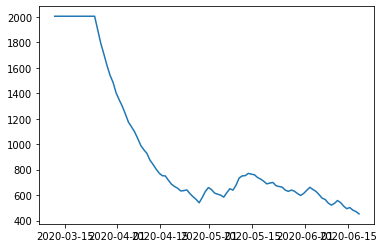





KDJ
                             K          D          J
time                                                
2020-03-11 16:00:00  36.988952  45.662984  19.640887
2020-03-12 16:00:00  38.971385  43.432451  30.049254
2020-03-13 16:00:00  37.054192  41.306365  28.549848
2020-03-14 16:00:00  37.283698  39.965476  31.920141
2020-03-15 16:00:00  34.789101  38.240017  27.887267
...                        ...        ...        ...
2020-06-14 16:00:00  39.841791  40.776421  37.972532
2020-06-15 16:00:00  45.507175  42.353339  51.814847
2020-06-16 16:00:00  47.422270  44.042982  54.180845
2020-06-17 16:00:00  46.271386  44.785784  49.242592
2020-06-18 16:00:00  43.106145  44.225904  40.866627

[100 rows x 3 columns]


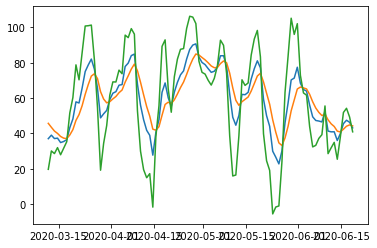





MACD
                          MACD  signal_line  histogram
time                                                  
2020-03-11 16:00:00  17.468590    17.468590   0.000000
2020-03-12 16:00:00  17.468590    17.468590   0.000000
2020-03-13 16:00:00   9.651670    14.264934  -4.613264
2020-03-14 16:00:00  12.692281    13.732192  -1.039911
2020-03-15 16:00:00   0.853124     9.900961  -9.047837
...                        ...          ...        ...
2020-06-14 16:00:00  78.819463   149.122964 -70.303501
2020-06-15 16:00:00  72.993897   133.897151 -60.903254
2020-06-16 16:00:00  62.777982   119.673317 -56.895335
2020-06-17 16:00:00  47.773868   105.293427 -57.519559
2020-06-18 16:00:00  28.423635    89.919469 -61.495834

[100 rows x 3 columns]


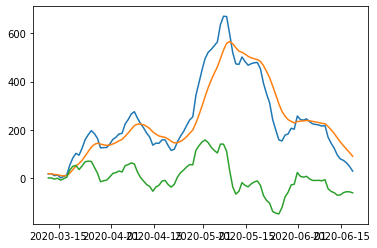





RSI
time
2020-03-11 16:00:00    100.000000
2020-03-12 16:00:00    100.000000
2020-03-13 16:00:00     65.859430
2020-03-14 16:00:00     71.496877
2020-03-15 16:00:00     54.050375
                          ...    
2020-06-14 16:00:00     46.578459
2020-06-15 16:00:00     51.020419
2020-06-16 16:00:00     48.239955
2020-06-17 16:00:00     44.562904
2020-06-18 16:00:00     40.530463
Name: close, Length: 100, dtype: float64


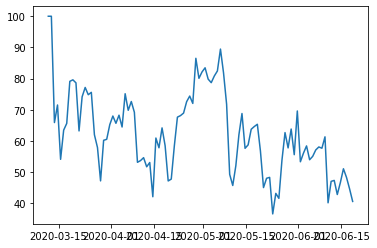





average_directional_index
                          ADX     PosDI     NegDI
time                                             
2020-04-06 16:00:00  0.377578  0.113679  0.030409
2020-04-07 16:00:00  0.398289  0.103032  0.033006
2020-04-08 16:00:00  0.350730  0.094058  0.080491
2020-04-09 16:00:00  0.310826  0.084243  0.072091
2020-04-10 16:00:00  0.303192  0.108975  0.064287
...                       ...       ...       ...
2020-06-13 16:00:00  0.321405  0.079097  0.232938
2020-06-14 16:00:00  0.327790  0.096718  0.209976
2020-06-15 16:00:00  0.343575  0.082366  0.215082
2020-06-16 16:00:00  0.357256  0.074412  0.194312
2020-06-17 16:00:00  0.374351  0.065989  0.190513

[73 rows x 3 columns]


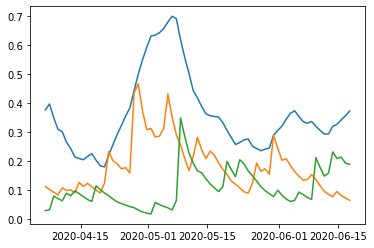





bollinger_bands
                           BB_up      BB_down    BB_width
time                                                     
2020-03-30 16:00:00  5946.466500  5946.466500    0.000000
2020-03-31 16:00:00  6059.216972  6018.008028   41.208944
2020-04-01 16:00:00  6138.369240  6060.404760   77.964479
2020-04-02 16:00:00  6239.860520  6115.117480  124.743040
2020-04-03 16:00:00  6340.590159  6163.956841  176.633318
...                          ...          ...         ...
2020-06-14 16:00:00  9706.072875  9492.728125  213.344750
2020-06-15 16:00:00  9723.115121  9507.837879  215.277242
2020-06-16 16:00:00  9713.641391  9506.236609  207.404781
2020-06-17 16:00:00  9702.936928  9512.866072  190.070856
2020-06-18 16:00:00  9674.759277  9501.061723  173.697554

[81 rows x 3 columns]


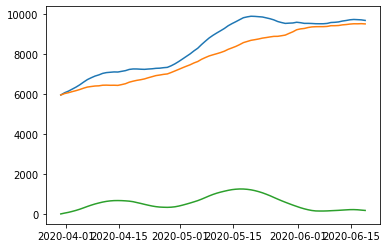





commodity_channel_index
time
2020-03-11 16:00:00         NaN
2020-03-12 16:00:00         NaN
2020-03-13 16:00:00         NaN
2020-03-14 16:00:00         NaN
2020-03-15 16:00:00         NaN
                         ...   
2020-06-14 16:00:00   -1.363669
2020-06-15 16:00:00   -0.498417
2020-06-16 16:00:00   -0.904614
2020-06-17 16:00:00   -1.073552
2020-06-18 16:00:00   -1.305076
Name: CCI, Length: 100, dtype: float64


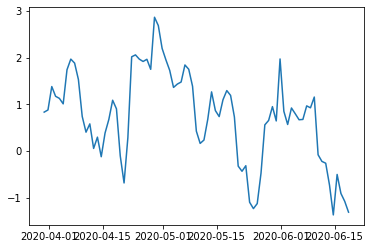





exponential_moving_average
                            open         high          low        close  \
time                                                                      
2020-03-11 16:00:00  7934.580000  7966.170000  4410.000000  4800.000000   
2020-03-12 16:00:00  5583.652500  6457.792500  3939.097500  5383.950000   
2020-03-13 16:00:00  5578.389231  5891.988462  4711.735385  5237.256923   
2020-03-14 16:00:00  5304.400500  5924.396250  4969.156500  5320.986000   
2020-03-15 16:00:00  5341.840909  5550.205537  4616.346942  5125.504215   
...                          ...          ...          ...          ...   
2020-06-14 16:00:00  9385.029981  9499.113902  9030.126339  9412.372743   
2020-06-15 16:00:00  9412.376660  9559.037967  9258.768780  9487.850914   
2020-06-16 16:00:00  9488.772220  9563.012656  9243.996260  9472.710305   
2020-06-17 16:00:00  9473.010740  9513.670885  9267.998753  9415.116768   
2020-06-18 16:00:00  9415.216913  9463.423628  9233.192918  9336.9722

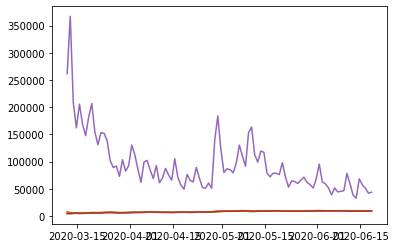





heikin_ashi
                            open         high          low      close
2020-03-11 16:00:00  7934.580000  7966.170000  4410.000000  6277.6875
2020-03-12 16:00:00  7106.133750  7106.133750  3782.130000  5028.9350
2020-03-13 16:00:00  6067.534375  6067.534375  5055.130000  5360.9400
2020-03-14 16:00:00  5714.237187  5940.000000  5093.100000  5391.7200
2020-03-15 16:00:00  5552.978594  5552.978594  4442.120000  5049.2100
...                          ...          ...          ...        ...
2020-06-14 16:00:00  9435.990218  9495.000000  8910.450000  9293.3925
2020-06-15 16:00:00  9364.691359  9589.000000  9364.691359  9478.4325
2020-06-16 16:00:00  9421.561929  9565.000000  9236.610000  9448.4300
2020-06-17 16:00:00  9434.995965  9489.000000  9280.000000  9405.1125
2020-06-18 16:00:00  9420.054232  9438.300000  9215.790000  9334.5775

[100 rows x 4 columns]


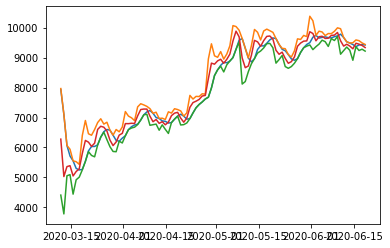





relative_volume_level
volume    0.995475
dtype: float64


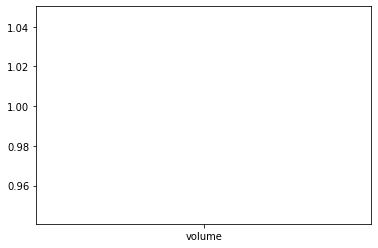





simple_moving_average
                         open      high       low     close         volume
time                                                                      
2020-03-11 16:00:00  6367.295  6960.585  4096.065  5189.300  331853.641209
2020-03-12 16:00:00  6367.295  6960.585  4096.065  5189.300  331853.641209
2020-03-13 16:00:00  5188.030  5797.760  4418.630  5375.330  269555.904869
2020-03-14 16:00:00  5374.265  5790.260  5074.115  5266.680  138413.141254
2020-03-15 16:00:00  5266.405  5652.710  4767.610  5195.135  183596.534647
...                       ...       ...       ...       ...            ...
2020-06-14 16:00:00  9407.720  9487.995  9077.725  9384.060   58081.715657
2020-06-15 16:00:00  9384.075  9542.000  9141.770  9475.805   69080.185817
2020-06-16 16:00:00  9476.510  9577.000  9304.850  9495.365   50049.429039
2020-06-17 16:00:00  9496.050  9527.000  9258.305  9425.730   42714.182458
2020-06-18 16:00:00  9425.725  9463.650  9247.895  9342.110   41005.214892

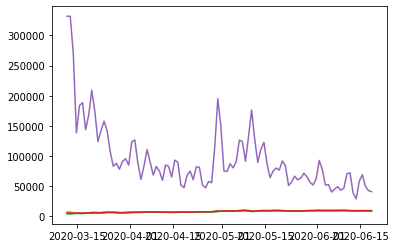





MACD_trigger
time
2020-03-11 16:00:00    0.0
2020-03-12 16:00:00    0.0
2020-03-13 16:00:00    0.0
2020-03-14 16:00:00    0.0
2020-03-15 16:00:00    0.0
                      ... 
2020-06-14 16:00:00    0.0
2020-06-15 16:00:00    0.0
2020-06-16 16:00:00    0.0
2020-06-17 16:00:00    0.0
2020-06-18 16:00:00    0.0
Name: histogram, Length: 100, dtype: float64


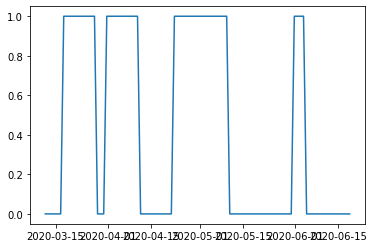





momentum_trigger
time
2020-03-11 16:00:00    0.0
2020-03-12 16:00:00    0.0
2020-03-13 16:00:00    0.0
2020-03-14 16:00:00    0.0
2020-03-15 16:00:00    0.0
                      ... 
2020-06-14 16:00:00    0.0
2020-06-15 16:00:00    1.0
2020-06-16 16:00:00    1.0
2020-06-17 16:00:00    1.0
2020-06-18 16:00:00    0.0
Length: 100, dtype: float64


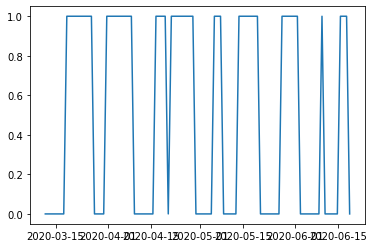





overtraded_trigger
time
2020-03-11 16:00:00    0.0
2020-03-12 16:00:00    0.0
2020-03-13 16:00:00    0.0
2020-03-14 16:00:00    0.0
2020-03-15 16:00:00    0.0
                      ... 
2020-06-14 16:00:00    0.0
2020-06-15 16:00:00    1.0
2020-06-16 16:00:00    0.0
2020-06-17 16:00:00    0.0
2020-06-18 16:00:00    0.0
Name: close, Length: 100, dtype: float64


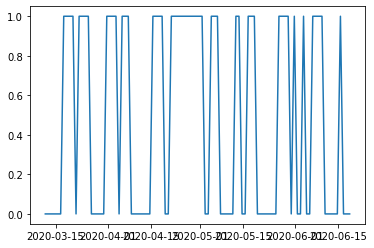





real_trigger
time
2020-03-11 16:00:00    0.0
2020-03-12 16:00:00    1.0
2020-03-13 16:00:00    0.0
2020-03-14 16:00:00    1.0
2020-03-15 16:00:00    0.0
                      ... 
2020-06-14 16:00:00    1.0
2020-06-15 16:00:00    1.0
2020-06-16 16:00:00    0.0
2020-06-17 16:00:00    0.0
2020-06-18 16:00:00    0.0
Length: 100, dtype: float64


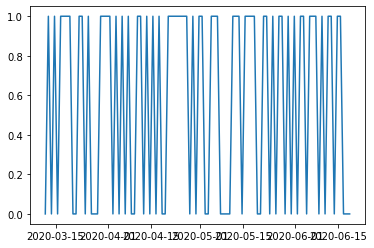





relative_volume_level_trigger
volume    0.0
dtype: float64


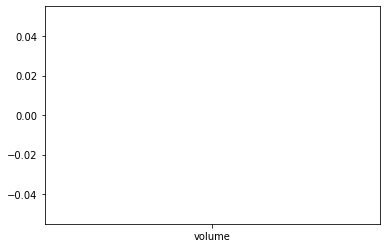





trend_strength_negative_trigger
time
2020-04-06 16:00:00    0.0
2020-04-07 16:00:00    0.0
2020-04-08 16:00:00    0.0
2020-04-09 16:00:00    0.0
2020-04-10 16:00:00    0.0
                      ... 
2020-06-13 16:00:00    1.0
2020-06-14 16:00:00    1.0
2020-06-15 16:00:00    1.0
2020-06-16 16:00:00    1.0
2020-06-17 16:00:00    1.0
Length: 73, dtype: float64


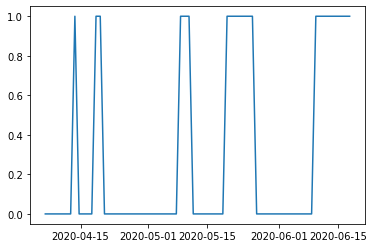





trend_strength_positive_trigger
time
2020-04-06 16:00:00    1.0
2020-04-07 16:00:00    1.0
2020-04-08 16:00:00    1.0
2020-04-09 16:00:00    1.0
2020-04-10 16:00:00    1.0
                      ... 
2020-06-13 16:00:00    0.0
2020-06-14 16:00:00    0.0
2020-06-15 16:00:00    0.0
2020-06-16 16:00:00    0.0
2020-06-17 16:00:00    0.0
Length: 73, dtype: float64


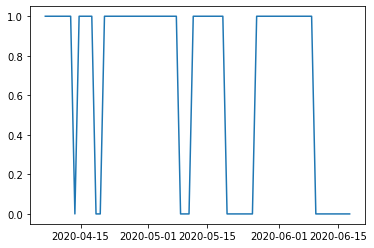





trend_strength_trigger
time
2020-04-06 16:00:00    1.0
2020-04-07 16:00:00    1.0
2020-04-08 16:00:00    1.0
2020-04-09 16:00:00    1.0
2020-04-10 16:00:00    1.0
                      ... 
2020-06-13 16:00:00    1.0
2020-06-14 16:00:00    1.0
2020-06-15 16:00:00    1.0
2020-06-16 16:00:00    1.0
2020-06-17 16:00:00    1.0
Name: ADX, Length: 73, dtype: float64


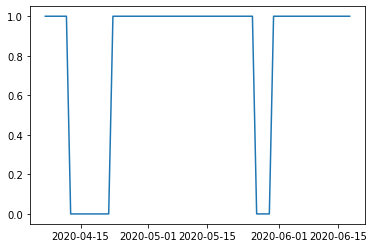





trend_trigger
time
2020-03-11 16:00:00    0.0
2020-03-12 16:00:00    1.0
2020-03-13 16:00:00    0.0
2020-03-14 16:00:00    1.0
2020-03-15 16:00:00    0.0
                      ... 
2020-06-14 16:00:00    1.0
2020-06-15 16:00:00    1.0
2020-06-16 16:00:00    0.0
2020-06-17 16:00:00    0.0
2020-06-18 16:00:00    0.0
Length: 100, dtype: float64


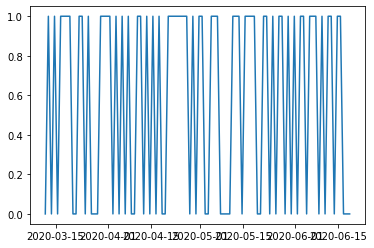





volatility_trigger
time
2020-03-11 16:00:00    0.0
2020-03-12 16:00:00    0.0
2020-03-13 16:00:00    0.0
2020-03-14 16:00:00    0.0
2020-03-15 16:00:00    0.0
                      ... 
2020-06-14 16:00:00    1.0
2020-06-15 16:00:00    1.0
2020-06-16 16:00:00    1.0
2020-06-17 16:00:00    1.0
2020-06-18 16:00:00    1.0
Length: 100, dtype: float64


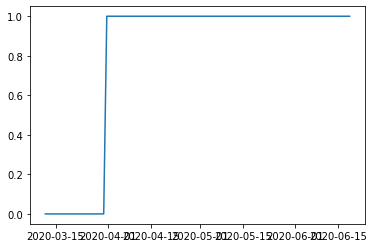





ATR
time
2020-03-11 16:00:00    2005.093144
2020-03-12 16:00:00    2005.093144
2020-03-13 16:00:00    2005.093144
2020-03-14 16:00:00    2005.093144
2020-03-15 16:00:00    2005.093144
                          ...     
2020-06-14 16:00:00     493.086073
2020-06-15 16:00:00     501.804211
2020-06-16 16:00:00     481.383196
2020-06-17 16:00:00     470.455110
2020-06-18 16:00:00     451.779745
Length: 100, dtype: float64


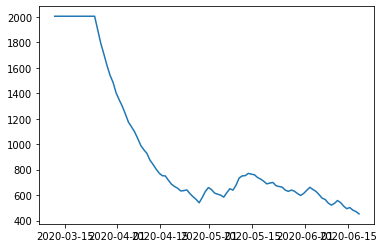





KDJ
                             K          D          J
time                                                
2020-03-11 16:00:00  36.988952  45.662984  19.640887
2020-03-12 16:00:00  38.971385  43.432451  30.049254
2020-03-13 16:00:00  37.054192  41.306365  28.549848
2020-03-14 16:00:00  37.283698  39.965476  31.920141
2020-03-15 16:00:00  34.789101  38.240017  27.887267
...                        ...        ...        ...
2020-06-14 16:00:00  39.841791  40.776421  37.972532
2020-06-15 16:00:00  45.507175  42.353339  51.814847
2020-06-16 16:00:00  47.422270  44.042982  54.180845
2020-06-17 16:00:00  46.271386  44.785784  49.242592
2020-06-18 16:00:00  43.050461  44.207343  40.736696

[100 rows x 3 columns]


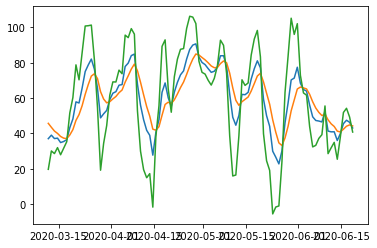





MACD
                          MACD  signal_line  histogram
time                                                  
2020-03-11 16:00:00  17.468590    17.468590   0.000000
2020-03-12 16:00:00  17.468590    17.468590   0.000000
2020-03-13 16:00:00   9.651670    14.264934  -4.613264
2020-03-14 16:00:00  12.692281    13.732192  -1.039911
2020-03-15 16:00:00   0.853124     9.900961  -9.047837
...                        ...          ...        ...
2020-06-14 16:00:00  78.819463   149.122964 -70.303501
2020-06-15 16:00:00  72.993897   133.897151 -60.903254
2020-06-16 16:00:00  62.777982   119.673317 -56.895335
2020-06-17 16:00:00  47.773868   105.293427 -57.519559
2020-06-18 16:00:00  28.283295    89.891401 -61.608106

[100 rows x 3 columns]


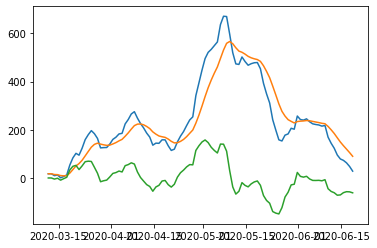





RSI
time
2020-03-11 16:00:00    100.000000
2020-03-12 16:00:00    100.000000
2020-03-13 16:00:00     65.859430
2020-03-14 16:00:00     71.496877
2020-03-15 16:00:00     54.050375
                          ...    
2020-06-14 16:00:00     46.578459
2020-06-15 16:00:00     51.020419
2020-06-16 16:00:00     48.239955
2020-06-17 16:00:00     44.562904
2020-06-18 16:00:00     40.457592
Name: close, Length: 100, dtype: float64


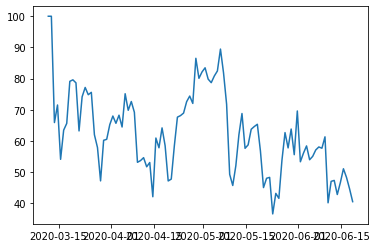





average_directional_index
                          ADX     PosDI     NegDI
time                                             
2020-04-06 16:00:00  0.377578  0.113679  0.030409
2020-04-07 16:00:00  0.398289  0.103032  0.033006
2020-04-08 16:00:00  0.350730  0.094058  0.080491
2020-04-09 16:00:00  0.310826  0.084243  0.072091
2020-04-10 16:00:00  0.303192  0.108975  0.064287
...                       ...       ...       ...
2020-06-13 16:00:00  0.321405  0.079097  0.232938
2020-06-14 16:00:00  0.327790  0.096718  0.209976
2020-06-15 16:00:00  0.343575  0.082366  0.215082
2020-06-16 16:00:00  0.357256  0.074412  0.194312
2020-06-17 16:00:00  0.374351  0.065989  0.190513

[73 rows x 3 columns]


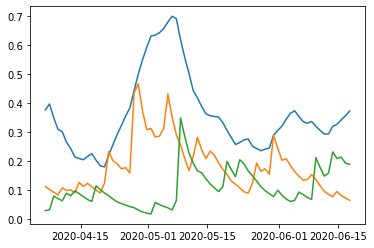





bollinger_bands
                           BB_up      BB_down    BB_width
time                                                     
2020-03-30 16:00:00  5946.466500  5946.466500    0.000000
2020-03-31 16:00:00  6059.216972  6018.008028   41.208944
2020-04-01 16:00:00  6138.369240  6060.404760   77.964479
2020-04-02 16:00:00  6239.860520  6115.117480  124.743040
2020-04-03 16:00:00  6340.590159  6163.956841  176.633318
...                          ...          ...         ...
2020-06-14 16:00:00  9706.072875  9492.728125  213.344750
2020-06-15 16:00:00  9723.115121  9507.837879  215.277242
2020-06-16 16:00:00  9713.641391  9506.236609  207.404781
2020-06-17 16:00:00  9702.936928  9512.866072  190.070856
2020-06-18 16:00:00  9674.666024  9500.978976  173.687047

[81 rows x 3 columns]


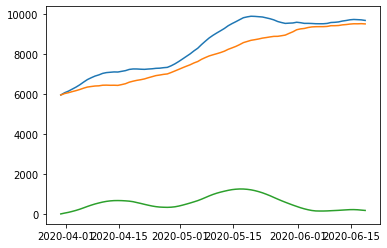





commodity_channel_index
time
2020-03-11 16:00:00         NaN
2020-03-12 16:00:00         NaN
2020-03-13 16:00:00         NaN
2020-03-14 16:00:00         NaN
2020-03-15 16:00:00         NaN
                         ...   
2020-06-14 16:00:00   -1.363669
2020-06-15 16:00:00   -0.498417
2020-06-16 16:00:00   -0.904614
2020-06-17 16:00:00   -1.073552
2020-06-18 16:00:00   -1.307716
Name: CCI, Length: 100, dtype: float64


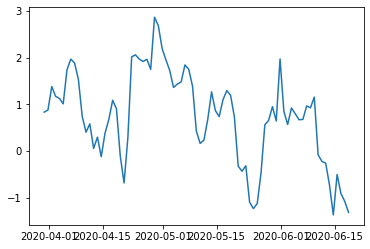





exponential_moving_average
                            open         high          low        close  \
time                                                                      
2020-03-11 16:00:00  7934.580000  7966.170000  4410.000000  4800.000000   
2020-03-12 16:00:00  5583.652500  6457.792500  3939.097500  5383.950000   
2020-03-13 16:00:00  5578.389231  5891.988462  4711.735385  5237.256923   
2020-03-14 16:00:00  5304.400500  5924.396250  4969.156500  5320.986000   
2020-03-15 16:00:00  5341.840909  5550.205537  4616.346942  5125.504215   
...                          ...          ...          ...          ...   
2020-06-14 16:00:00  9385.029981  9499.113902  9030.126339  9412.372743   
2020-06-15 16:00:00  9412.376660  9559.037967  9258.768780  9487.850914   
2020-06-16 16:00:00  9488.772220  9563.012656  9243.996260  9472.710305   
2020-06-17 16:00:00  9473.010740  9513.670885  9267.998753  9415.116768   
2020-06-18 16:00:00  9415.216913  9463.423628  9233.192918  9335.7989

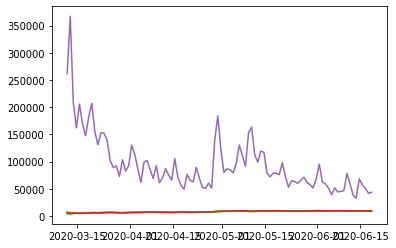





heikin_ashi
                            open         high          low      close
2020-03-11 16:00:00  7934.580000  7966.170000  4410.000000  6277.6875
2020-03-12 16:00:00  7106.133750  7106.133750  3782.130000  5028.9350
2020-03-13 16:00:00  6067.534375  6067.534375  5055.130000  5360.9400
2020-03-14 16:00:00  5714.237187  5940.000000  5093.100000  5391.7200
2020-03-15 16:00:00  5552.978594  5552.978594  4442.120000  5049.2100
...                          ...          ...          ...        ...
2020-06-14 16:00:00  9435.990218  9495.000000  8910.450000  9293.3925
2020-06-15 16:00:00  9364.691359  9589.000000  9364.691359  9478.4325
2020-06-16 16:00:00  9421.561929  9565.000000  9236.610000  9448.4300
2020-06-17 16:00:00  9434.995965  9489.000000  9280.000000  9405.1125
2020-06-18 16:00:00  9420.054232  9438.300000  9215.790000  9334.1375

[100 rows x 4 columns]


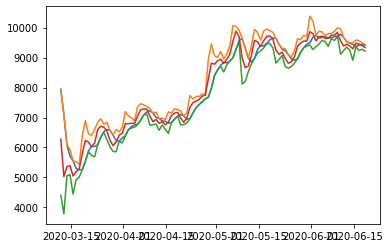





relative_volume_level
volume    0.995476
dtype: float64


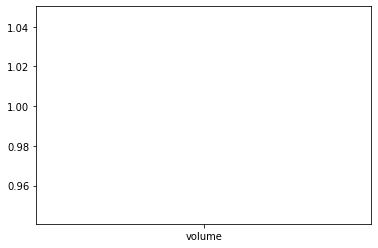





simple_moving_average
                         open      high       low     close         volume
time                                                                      
2020-03-11 16:00:00  6367.295  6960.585  4096.065  5189.300  331853.641209
2020-03-12 16:00:00  6367.295  6960.585  4096.065  5189.300  331853.641209
2020-03-13 16:00:00  5188.030  5797.760  4418.630  5375.330  269555.904869
2020-03-14 16:00:00  5374.265  5790.260  5074.115  5266.680  138413.141254
2020-03-15 16:00:00  5266.405  5652.710  4767.610  5195.135  183596.534647
...                       ...       ...       ...       ...            ...
2020-06-14 16:00:00  9407.720  9487.995  9077.725  9384.060   58081.715657
2020-06-15 16:00:00  9384.075  9542.000  9141.770  9475.805   69080.185817
2020-06-16 16:00:00  9476.510  9577.000  9304.850  9495.365   50049.429039
2020-06-17 16:00:00  9496.050  9527.000  9258.305  9425.730   42714.182458
2020-06-18 16:00:00  9425.725  9463.650  9247.895  9341.230   41005.521717

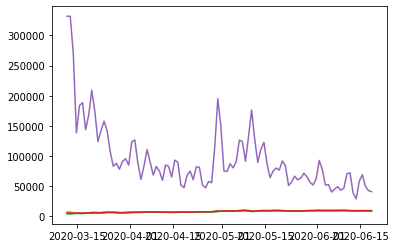





MACD_trigger
time
2020-03-11 16:00:00    0.0
2020-03-12 16:00:00    0.0
2020-03-13 16:00:00    0.0
2020-03-14 16:00:00    0.0
2020-03-15 16:00:00    0.0
                      ... 
2020-06-14 16:00:00    0.0
2020-06-15 16:00:00    0.0
2020-06-16 16:00:00    0.0
2020-06-17 16:00:00    0.0
2020-06-18 16:00:00    0.0
Name: histogram, Length: 100, dtype: float64


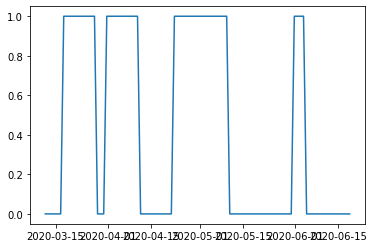





momentum_trigger
time
2020-03-11 16:00:00    0.0
2020-03-12 16:00:00    0.0
2020-03-13 16:00:00    0.0
2020-03-14 16:00:00    0.0
2020-03-15 16:00:00    0.0
                      ... 
2020-06-14 16:00:00    0.0
2020-06-15 16:00:00    1.0
2020-06-16 16:00:00    1.0
2020-06-17 16:00:00    1.0
2020-06-18 16:00:00    0.0
Length: 100, dtype: float64


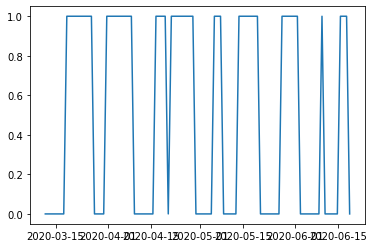





overtraded_trigger
time
2020-03-11 16:00:00    0.0
2020-03-12 16:00:00    0.0
2020-03-13 16:00:00    0.0
2020-03-14 16:00:00    0.0
2020-03-15 16:00:00    0.0
                      ... 
2020-06-14 16:00:00    0.0
2020-06-15 16:00:00    1.0
2020-06-16 16:00:00    0.0
2020-06-17 16:00:00    0.0
2020-06-18 16:00:00    0.0
Name: close, Length: 100, dtype: float64


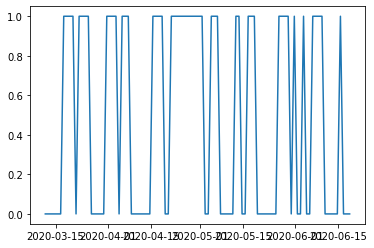





real_trigger
time
2020-03-11 16:00:00    0.0
2020-03-12 16:00:00    1.0
2020-03-13 16:00:00    0.0
2020-03-14 16:00:00    1.0
2020-03-15 16:00:00    0.0
                      ... 
2020-06-14 16:00:00    1.0
2020-06-15 16:00:00    1.0
2020-06-16 16:00:00    0.0
2020-06-17 16:00:00    0.0
2020-06-18 16:00:00    0.0
Length: 100, dtype: float64


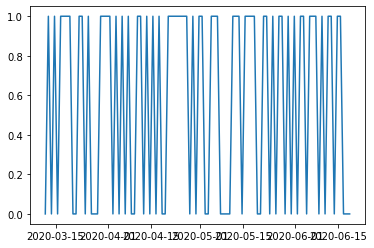





relative_volume_level_trigger
volume    0.0
dtype: float64


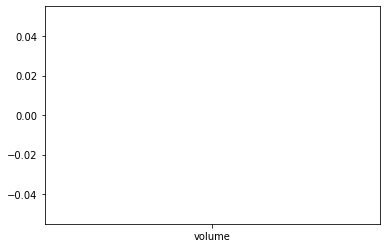





trend_strength_negative_trigger
time
2020-04-06 16:00:00    0.0
2020-04-07 16:00:00    0.0
2020-04-08 16:00:00    0.0
2020-04-09 16:00:00    0.0
2020-04-10 16:00:00    0.0
                      ... 
2020-06-13 16:00:00    1.0
2020-06-14 16:00:00    1.0
2020-06-15 16:00:00    1.0
2020-06-16 16:00:00    1.0
2020-06-17 16:00:00    1.0
Length: 73, dtype: float64


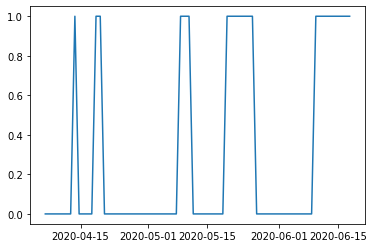





trend_strength_positive_trigger
time
2020-04-06 16:00:00    1.0
2020-04-07 16:00:00    1.0
2020-04-08 16:00:00    1.0
2020-04-09 16:00:00    1.0
2020-04-10 16:00:00    1.0
                      ... 
2020-06-13 16:00:00    0.0
2020-06-14 16:00:00    0.0
2020-06-15 16:00:00    0.0
2020-06-16 16:00:00    0.0
2020-06-17 16:00:00    0.0
Length: 73, dtype: float64


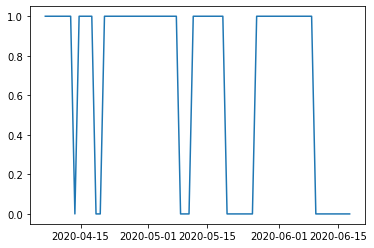





trend_strength_trigger
time
2020-04-06 16:00:00    1.0
2020-04-07 16:00:00    1.0
2020-04-08 16:00:00    1.0
2020-04-09 16:00:00    1.0
2020-04-10 16:00:00    1.0
                      ... 
2020-06-13 16:00:00    1.0
2020-06-14 16:00:00    1.0
2020-06-15 16:00:00    1.0
2020-06-16 16:00:00    1.0
2020-06-17 16:00:00    1.0
Name: ADX, Length: 73, dtype: float64


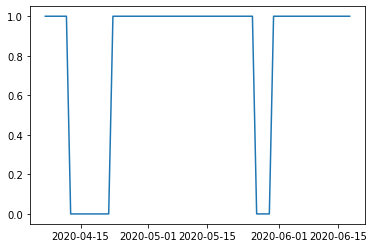





trend_trigger
time
2020-03-11 16:00:00    0.0
2020-03-12 16:00:00    1.0
2020-03-13 16:00:00    0.0
2020-03-14 16:00:00    1.0
2020-03-15 16:00:00    0.0
                      ... 
2020-06-14 16:00:00    1.0
2020-06-15 16:00:00    1.0
2020-06-16 16:00:00    0.0
2020-06-17 16:00:00    0.0
2020-06-18 16:00:00    0.0
Length: 100, dtype: float64


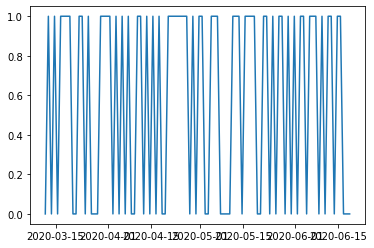





volatility_trigger
time
2020-03-11 16:00:00    0.0
2020-03-12 16:00:00    0.0
2020-03-13 16:00:00    0.0
2020-03-14 16:00:00    0.0
2020-03-15 16:00:00    0.0
                      ... 
2020-06-14 16:00:00    1.0
2020-06-15 16:00:00    1.0
2020-06-16 16:00:00    1.0
2020-06-17 16:00:00    1.0
2020-06-18 16:00:00    1.0
Length: 100, dtype: float64


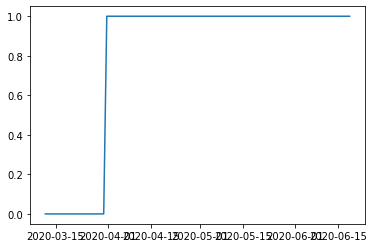

In [5]:
client = Client(api_key, api_secret)

crypto_bot = Cryptocurrency_bot(client=client, 
                                traded_asset_symbols=traded_asset_symbols, 
                                intervals=intervals, 
                                raw_price=raw_price, 
                                initial_plot=initial_plot)



ATR
time
2020-03-11 16:00:00    2005.093144
2020-03-12 16:00:00    2005.093144
2020-03-13 16:00:00    2005.093144
2020-03-14 16:00:00    2005.093144
2020-03-15 16:00:00    2005.093144
                          ...     
2020-06-14 16:00:00     493.086073
2020-06-15 16:00:00     501.804211
2020-06-16 16:00:00     481.383196
2020-06-17 16:00:00     470.455110
2020-06-18 16:00:00     451.779745
Length: 100, dtype: float64


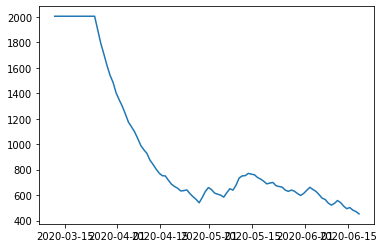





KDJ
                             K          D          J
time                                                
2020-03-11 16:00:00  36.988952  45.662984  19.640887
2020-03-12 16:00:00  38.971385  43.432451  30.049254
2020-03-13 16:00:00  37.054192  41.306365  28.549848
2020-03-14 16:00:00  37.283698  39.965476  31.920141
2020-03-15 16:00:00  34.789101  38.240017  27.887267
...                        ...        ...        ...
2020-06-14 16:00:00  39.841791  40.776421  37.972532
2020-06-15 16:00:00  45.507175  42.353339  51.814847
2020-06-16 16:00:00  47.422270  44.042982  54.180845
2020-06-17 16:00:00  46.271386  44.785784  49.242592
2020-06-18 16:00:00  43.050461  44.207343  40.736696

[100 rows x 3 columns]


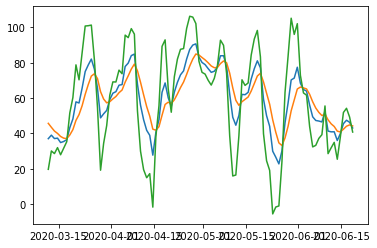





MACD
                          MACD  signal_line  histogram
time                                                  
2020-03-11 16:00:00  17.468590    17.468590   0.000000
2020-03-12 16:00:00  17.468590    17.468590   0.000000
2020-03-13 16:00:00   9.651670    14.264934  -4.613264
2020-03-14 16:00:00  12.692281    13.732192  -1.039911
2020-03-15 16:00:00   0.853124     9.900961  -9.047837
...                        ...          ...        ...
2020-06-14 16:00:00  78.819463   149.122964 -70.303501
2020-06-15 16:00:00  72.993897   133.897151 -60.903254
2020-06-16 16:00:00  62.777982   119.673317 -56.895335
2020-06-17 16:00:00  47.773868   105.293427 -57.519559
2020-06-18 16:00:00  28.283295    89.891401 -61.608106

[100 rows x 3 columns]


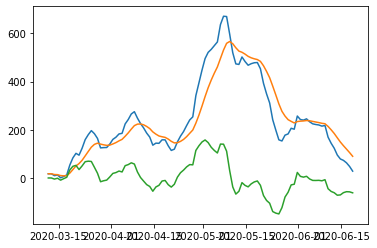





RSI
time
2020-03-11 16:00:00    100.000000
2020-03-12 16:00:00    100.000000
2020-03-13 16:00:00     65.859430
2020-03-14 16:00:00     71.496877
2020-03-15 16:00:00     54.050375
                          ...    
2020-06-14 16:00:00     46.578459
2020-06-15 16:00:00     51.020419
2020-06-16 16:00:00     48.239955
2020-06-17 16:00:00     44.562904
2020-06-18 16:00:00     40.457592
Name: close, Length: 100, dtype: float64


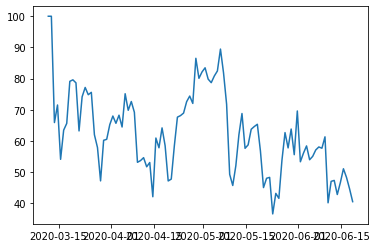





average_directional_index
                          ADX     PosDI     NegDI
time                                             
2020-04-06 16:00:00  0.377578  0.113679  0.030409
2020-04-07 16:00:00  0.398289  0.103032  0.033006
2020-04-08 16:00:00  0.350730  0.094058  0.080491
2020-04-09 16:00:00  0.310826  0.084243  0.072091
2020-04-10 16:00:00  0.303192  0.108975  0.064287
...                       ...       ...       ...
2020-06-13 16:00:00  0.321405  0.079097  0.232938
2020-06-14 16:00:00  0.327790  0.096718  0.209976
2020-06-15 16:00:00  0.343575  0.082366  0.215082
2020-06-16 16:00:00  0.357256  0.074412  0.194312
2020-06-17 16:00:00  0.374351  0.065989  0.190513

[73 rows x 3 columns]


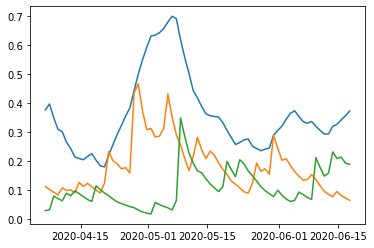





bollinger_bands
                           BB_up      BB_down    BB_width
time                                                     
2020-03-30 16:00:00  5946.466500  5946.466500    0.000000
2020-03-31 16:00:00  6059.216972  6018.008028   41.208944
2020-04-01 16:00:00  6138.369240  6060.404760   77.964479
2020-04-02 16:00:00  6239.860520  6115.117480  124.743040
2020-04-03 16:00:00  6340.590159  6163.956841  176.633318
...                          ...          ...         ...
2020-06-14 16:00:00  9706.072875  9492.728125  213.344750
2020-06-15 16:00:00  9723.115121  9507.837879  215.277242
2020-06-16 16:00:00  9713.641391  9506.236609  207.404781
2020-06-17 16:00:00  9702.936928  9512.866072  190.070856
2020-06-18 16:00:00  9674.666024  9500.978976  173.687047

[81 rows x 3 columns]


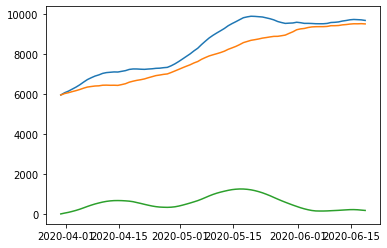





commodity_channel_index
time
2020-03-11 16:00:00         NaN
2020-03-12 16:00:00         NaN
2020-03-13 16:00:00         NaN
2020-03-14 16:00:00         NaN
2020-03-15 16:00:00         NaN
                         ...   
2020-06-14 16:00:00   -1.363669
2020-06-15 16:00:00   -0.498417
2020-06-16 16:00:00   -0.904614
2020-06-17 16:00:00   -1.073552
2020-06-18 16:00:00   -1.307716
Name: CCI, Length: 100, dtype: float64


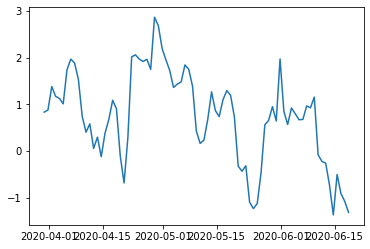





exponential_moving_average
                            open         high          low        close  \
time                                                                      
2020-03-11 16:00:00  7934.580000  7966.170000  4410.000000  4800.000000   
2020-03-12 16:00:00  5583.652500  6457.792500  3939.097500  5383.950000   
2020-03-13 16:00:00  5578.389231  5891.988462  4711.735385  5237.256923   
2020-03-14 16:00:00  5304.400500  5924.396250  4969.156500  5320.986000   
2020-03-15 16:00:00  5341.840909  5550.205537  4616.346942  5125.504215   
...                          ...          ...          ...          ...   
2020-06-14 16:00:00  9385.029981  9499.113902  9030.126339  9412.372743   
2020-06-15 16:00:00  9412.376660  9559.037967  9258.768780  9487.850914   
2020-06-16 16:00:00  9488.772220  9563.012656  9243.996260  9472.710305   
2020-06-17 16:00:00  9473.010740  9513.670885  9267.998753  9415.116768   
2020-06-18 16:00:00  9415.216913  9463.423628  9233.192918  9335.7989

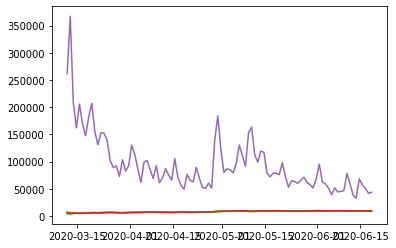





heikin_ashi
                            open         high          low      close
2020-03-11 16:00:00  7934.580000  7966.170000  4410.000000  6277.6875
2020-03-12 16:00:00  7106.133750  7106.133750  3782.130000  5028.9350
2020-03-13 16:00:00  6067.534375  6067.534375  5055.130000  5360.9400
2020-03-14 16:00:00  5714.237187  5940.000000  5093.100000  5391.7200
2020-03-15 16:00:00  5552.978594  5552.978594  4442.120000  5049.2100
...                          ...          ...          ...        ...
2020-06-14 16:00:00  9435.990218  9495.000000  8910.450000  9293.3925
2020-06-15 16:00:00  9364.691359  9589.000000  9364.691359  9478.4325
2020-06-16 16:00:00  9421.561929  9565.000000  9236.610000  9448.4300
2020-06-17 16:00:00  9434.995965  9489.000000  9280.000000  9405.1125
2020-06-18 16:00:00  9420.054232  9438.300000  9215.790000  9334.1375

[100 rows x 4 columns]


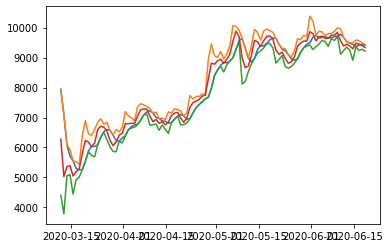





relative_volume_level
volume    0.995476
dtype: float64


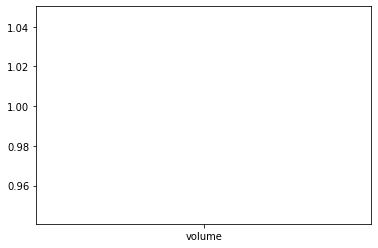





simple_moving_average
                         open      high       low     close         volume
time                                                                      
2020-03-11 16:00:00  6367.295  6960.585  4096.065  5189.300  331853.641209
2020-03-12 16:00:00  6367.295  6960.585  4096.065  5189.300  331853.641209
2020-03-13 16:00:00  5188.030  5797.760  4418.630  5375.330  269555.904869
2020-03-14 16:00:00  5374.265  5790.260  5074.115  5266.680  138413.141254
2020-03-15 16:00:00  5266.405  5652.710  4767.610  5195.135  183596.534647
...                       ...       ...       ...       ...            ...
2020-06-14 16:00:00  9407.720  9487.995  9077.725  9384.060   58081.715657
2020-06-15 16:00:00  9384.075  9542.000  9141.770  9475.805   69080.185817
2020-06-16 16:00:00  9476.510  9577.000  9304.850  9495.365   50049.429039
2020-06-17 16:00:00  9496.050  9527.000  9258.305  9425.730   42714.182458
2020-06-18 16:00:00  9425.725  9463.650  9247.895  9341.230   41005.521717

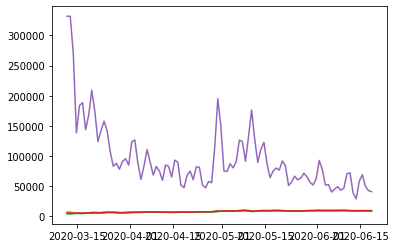





MACD_trigger
time
2020-03-11 16:00:00    0.0
2020-03-12 16:00:00    0.0
2020-03-13 16:00:00    0.0
2020-03-14 16:00:00    0.0
2020-03-15 16:00:00    0.0
                      ... 
2020-06-14 16:00:00    0.0
2020-06-15 16:00:00    0.0
2020-06-16 16:00:00    0.0
2020-06-17 16:00:00    0.0
2020-06-18 16:00:00    0.0
Name: histogram, Length: 100, dtype: float64


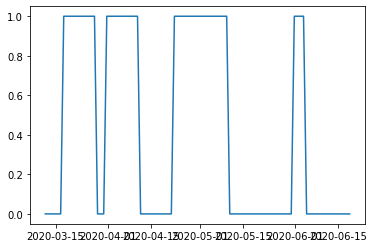





momentum_trigger
time
2020-03-11 16:00:00    0.0
2020-03-12 16:00:00    0.0
2020-03-13 16:00:00    0.0
2020-03-14 16:00:00    0.0
2020-03-15 16:00:00    0.0
                      ... 
2020-06-14 16:00:00    0.0
2020-06-15 16:00:00    1.0
2020-06-16 16:00:00    1.0
2020-06-17 16:00:00    1.0
2020-06-18 16:00:00    0.0
Length: 100, dtype: float64


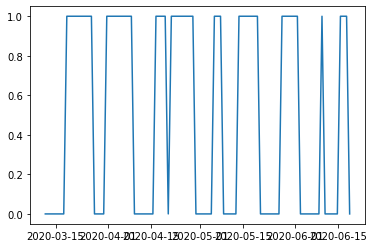





overtraded_trigger
time
2020-03-11 16:00:00    0.0
2020-03-12 16:00:00    0.0
2020-03-13 16:00:00    0.0
2020-03-14 16:00:00    0.0
2020-03-15 16:00:00    0.0
                      ... 
2020-06-14 16:00:00    0.0
2020-06-15 16:00:00    1.0
2020-06-16 16:00:00    0.0
2020-06-17 16:00:00    0.0
2020-06-18 16:00:00    0.0
Name: close, Length: 100, dtype: float64


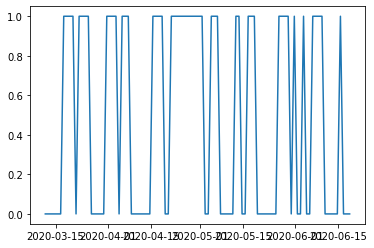





real_trigger
time
2020-03-11 16:00:00    0.0
2020-03-12 16:00:00    1.0
2020-03-13 16:00:00    0.0
2020-03-14 16:00:00    1.0
2020-03-15 16:00:00    0.0
                      ... 
2020-06-14 16:00:00    1.0
2020-06-15 16:00:00    1.0
2020-06-16 16:00:00    0.0
2020-06-17 16:00:00    0.0
2020-06-18 16:00:00    0.0
Length: 100, dtype: float64


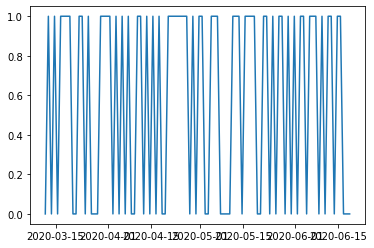





relative_volume_level_trigger
volume    0.0
dtype: float64


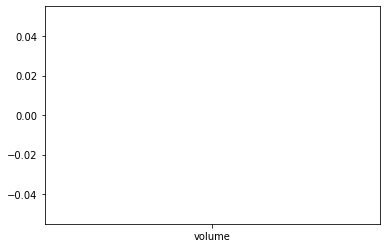





trend_strength_negative_trigger
time
2020-04-06 16:00:00    0.0
2020-04-07 16:00:00    0.0
2020-04-08 16:00:00    0.0
2020-04-09 16:00:00    0.0
2020-04-10 16:00:00    0.0
                      ... 
2020-06-13 16:00:00    1.0
2020-06-14 16:00:00    1.0
2020-06-15 16:00:00    1.0
2020-06-16 16:00:00    1.0
2020-06-17 16:00:00    1.0
Length: 73, dtype: float64


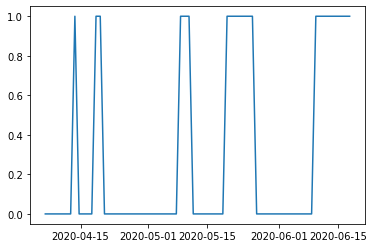





trend_strength_positive_trigger
time
2020-04-06 16:00:00    1.0
2020-04-07 16:00:00    1.0
2020-04-08 16:00:00    1.0
2020-04-09 16:00:00    1.0
2020-04-10 16:00:00    1.0
                      ... 
2020-06-13 16:00:00    0.0
2020-06-14 16:00:00    0.0
2020-06-15 16:00:00    0.0
2020-06-16 16:00:00    0.0
2020-06-17 16:00:00    0.0
Length: 73, dtype: float64


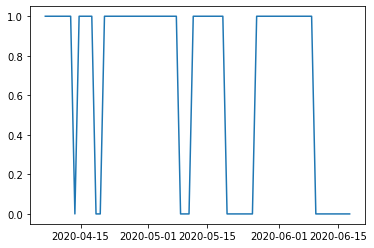





trend_strength_trigger
time
2020-04-06 16:00:00    1.0
2020-04-07 16:00:00    1.0
2020-04-08 16:00:00    1.0
2020-04-09 16:00:00    1.0
2020-04-10 16:00:00    1.0
                      ... 
2020-06-13 16:00:00    1.0
2020-06-14 16:00:00    1.0
2020-06-15 16:00:00    1.0
2020-06-16 16:00:00    1.0
2020-06-17 16:00:00    1.0
Name: ADX, Length: 73, dtype: float64


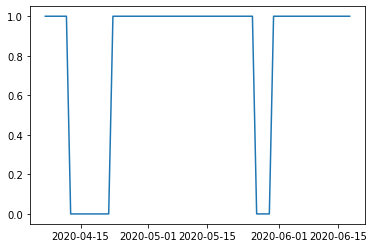





trend_trigger
time
2020-03-11 16:00:00    0.0
2020-03-12 16:00:00    1.0
2020-03-13 16:00:00    0.0
2020-03-14 16:00:00    1.0
2020-03-15 16:00:00    0.0
                      ... 
2020-06-14 16:00:00    1.0
2020-06-15 16:00:00    1.0
2020-06-16 16:00:00    0.0
2020-06-17 16:00:00    0.0
2020-06-18 16:00:00    0.0
Length: 100, dtype: float64


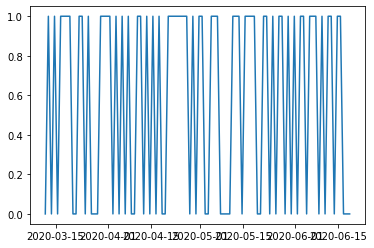





volatility_trigger
time
2020-03-11 16:00:00    0.0
2020-03-12 16:00:00    0.0
2020-03-13 16:00:00    0.0
2020-03-14 16:00:00    0.0
2020-03-15 16:00:00    0.0
                      ... 
2020-06-14 16:00:00    1.0
2020-06-15 16:00:00    1.0
2020-06-16 16:00:00    1.0
2020-06-17 16:00:00    1.0
2020-06-18 16:00:00    1.0
Length: 100, dtype: float64


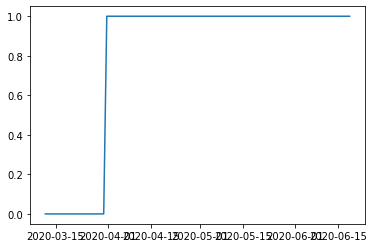

In [6]:
indicators = Cryptocurrency_indicators(crypto_bot.pairs['BTCUSDT'].interval['1d'].dataset)

In [ ]:
def process_message(msg):
    global crypto_bot
    four_hours = 14400
    milliseconds = 1000
    percentage_to_trade = 0.9999

    msg = msg['data']['k']
    symbol = msg['s']
    interval = msg['i']
    pair = crypto_bot.pairs[symbol]
    pair_at_interval = pair.interval[interval]
    dataset = pair_at_interval.dataset
    precision = pair.info.precision
    if symbol in crypto_bot.pairs.keys():
        last_data = \
            pd.DataFrame([["{:0.0{}f}".format(float(msg['o']), precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['h']), precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['l']), precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['c']), precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['v']), precision).rstrip('0').rstrip('.')]], 
                         index=[datetime.datetime.fromtimestamp(int(msg['t'] / milliseconds) - four_hours)], 
                         columns=['open', 'high', 'low', 'close', 'volume'])

        last_data.index.name = 'time'

        if dataset.index[-1] == last_data.index[-1]:
            dataset = dataset.iloc[:-1].append(last_data).iloc[-1000:]
        else:
            dataset = dataset.append(last_data).iloc[-1000:]

        pair_at_interval.dataset = dataset
        pair_at_interval.indicators.update(dataset, plot=False)
        pair.info.calculate_balance()
        pair.info.print_balance()

        if symbol == crypto_bot.traded_pair_symbol:
            volatility_trigger = pair_at_interval.indicators.volatility_trigger.value.iloc[-1]
            MACD_trigger = pair_at_interval.indicators.MACD_trigger.value.iloc[-1]
            real_trigger = pair_at_interval.indicators.real_trigger.value.iloc[-1]
            momentum_trigger = pair_at_interval.indicators.momentum_trigger.value.iloc[-1]

            if pair.state == 'exit':

                if pair.position == 'sell' and \
                        volatility_trigger and \
                        MACD_trigger and \
                        real_trigger and \
                        momentum_trigger:

                    pair.trade(percentage_to_trade=percentage_to_trade)

                elif pair.position == 'buy' and \
                        volatility_trigger and \
                        not MACD_trigger and \
                        not real_trigger and \
                        not momentum_trigger:

                    pair.trade(percentage_to_trade=percentage_to_trade)

            elif pair.state == 'entry':

                if pair.position == 'sell' and \
                        volatility_trigger and \
                        MACD_trigger and \
                        real_trigger and \
                        momentum_trigger:

                    pair.trade(percentage_to_trade=percentage_to_trade)

                elif pair.position == 'buy' and \
                        volatility_trigger and \
                        not MACD_trigger and \
                        not real_trigger and \
                        not momentum_trigger:

                    pair.trade(percentage_to_trade=percentage_to_trade)

bm = BinanceSocketManager(client, user_timeout=43200)

sockets = []

for interval in intervals:
    for symbol in crypto_bot.pairs.keys():
        sockets.append(symbol.lower() + '@kline_' + interval)

conn_key = bm.start_multiplex_socket(sockets, process_message)

bm.start()

'''
scores = {}
for crypto_pair in symbols.values():
    scores.update({crypto_pair.base_asset: 0})
    scores.update({crypto_pair.quote_asset: 0})

while True:
    time.sleep(15)
    for symbol in symbols.keys():
        symbols[symbol].calculate_balance()
        symbols[symbol].calculate_position()

    scores = {}
    for crypto_pair in symbols.values():
        scores.update({crypto_pair.base_asset: 0})
        scores.update({crypto_pair.quote_asset: 0})

    for asset in scores.keys():
        for symbol in symbols.keys():
            if symbols[symbol].base_asset == asset:
                if symbols[symbol].real_trigger.iloc[-1] and \
                        symbols[symbol].real_trigger_10m.iloc[-1]:
                    scores.update({asset: scores[asset] + 1})
                else:
                    scores.update({asset: scores[asset] - 1})
            elif symbols[symbol].quote_asset == asset:
                if symbols[symbol].real_trigger.iloc[-1] and \
                        symbols[symbol].real_trigger_10m.iloc[-1]:
                    scores.update({asset: scores[asset] - 1})
                else:
                    scores.update({asset: scores[asset] + 1})

    assets = scores.keys()
    best_assets = [asset for asset in scores.keys() if scores[asset] > 0]
    print('best_assets: ', best_assets)

    if best_assets != [] and \
            not (symbols[traded_symbol].base_asset in best_assets or \
            symbols[traded_symbol].quote_asset in best_assets):

        if symbols[traded_symbol].position == 'buy':
            asset = symbols[traded_symbol].base_asset
        elif symbols[traded_symbol].position == 'sell':
            asset = symbols[traded_symbol].quote_asset

        target_symbols = [symbol for symbol in symbols.keys() \
                          if asset in symbol and any([asset in symbol for asset in best_assets])]

        target_symbol = target_symbols[0]
        symbols[target_symbol].state = 'exit'

        if symbols[target_symbol].base_asset == asset:
            symbols[target_symbol].position = 'buy'
        elif symbols[target_symbol].quote_asset == asset:
            symbols[target_symbol].position = 'sell'

        traded_symbol = target_symbol
'''

In [ ]:
# --- Development separation --- #

In [ ]:
'''
def process_message(msg):
    global symbols, traded_symbol
    four_hours = 14400
    milliseconds = 1000

    msg = msg['data']['k']
    symbol = msg['s']
    dataset = symbols[symbol].dataset
    quote_asset_precision = symbols[symbol].quote_asset_precision
    if symbol in symbols.keys():
        last_data = \
            pd.DataFrame([["{:0.0{}f}".format(float(msg['o']), quote_asset_precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['h']), quote_asset_precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['l']), quote_asset_precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['c']), quote_asset_precision).rstrip('0').rstrip('.'), 
                           "{:0.0{}f}".format(float(msg['v']), quote_asset_precision).rstrip('0').rstrip('.')]], 
                         index=[datetime.datetime.fromtimestamp(int(msg['t'] / milliseconds) - four_hours)], 
                         columns=['open', 'high', 'low', 'close', 'volume'])

        last_data.index.name = 'time'

        if dataset.index[-1] == last_data.index[-1]:
            dataset = dataset.iloc[:-1].append(last_data).iloc[-1000:]
        else:
            dataset = dataset.append(last_data).iloc[-1000:]

        symbols[symbol].dataset = dataset
        symbols[symbol].calculate_indicators()

        if symbol == traded_symbol:
            if symbols[symbol].state == 'exit':

                if symbols[symbol].position == 'sell' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        symbols[symbol].MACD_trigger.iloc[-1] and \
                        symbols[symbol].real_trigger.iloc[-1] and \
                        symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

                elif symbols[symbol].position == 'buy' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        not symbols[symbol].MACD_trigger.iloc[-1] and \
                        not symbols[symbol].real_trigger.iloc[-1] and \
                        not symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

            elif symbols[symbol].state == 'entry':

                if symbols[symbol].position == 'sell' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        symbols[symbol].MACD_trigger.iloc[-1] and \
                        symbols[symbol].real_trigger.iloc[-1] and \
                        symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

                elif symbols[symbol].position == 'buy' and \
                        symbols[symbol].volatility_trigger.iloc[-1] and \
                        not symbols[symbol].MACD_trigger.iloc[-1] and \
                        not symbols[symbol].real_trigger.iloc[-1] and \
                        not symbols[symbol].momentum_trigger.iloc[-1]:

                    symbols[symbol].trade()

bm = BinanceSocketManager(client, user_timeout=43200)
conn_key = bm.start_multiplex_socket([symbol.lower() + '@kline_' + interval for symbol in symbols.keys()], 
                                     process_message)
bm.start()
'''

In [ ]:
#bm.stop_socket(conn_key)
#bm.close()
#reactor.stop()